In [1]:
# PySpark SQL and DataFrame functionality
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, current_date, datediff, months_between,
    round, lit, concat
)
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.sql import Row

# PySpark ML features and models
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession.builder \
    .appName("Fraud money prediction") \
    .master("local[*]") \
    .getOrCreate()

In [ ]:
# this function adds age variable 
# and filters only fraud rows

def making_df_for_analysis(df):
    print(f"Rows in the original dataset: {df.count()}")
    
    df_with_age=df.withColumn("age", round(months_between(col('trans_date_trans_time'), col("dob")) / lit(12), 0))\
    .filter(col('is_fraud')==1)
    print(f"Rows in the dataset, which contains only fraud data: {df_with_age.count()}")
    return df_with_age


#setting column types
def column_types(df):
    df_with_column_types=df.withColumn("age",df.age.cast('int'))\
    .withColumn("category",df.category.cast('string'))\
    .withColumn("gender",df.gender.cast('string'))\
    .withColumn("city",df.city.cast('string'))\
    .withColumn("job",df.job.cast('string'))\
    .withColumn("amt",df.amt.cast('double'))\
    .withColumn("city_pop",df.city_pop.cast('int'))
    return df_with_column_types

# printing unique values for each column
def print_unique(df):
    for column in df.columns:
        if column != "amt":
            unique=df.select(column).distinct().collect()
            print(f"Column:{column}, unique values: {len(unique)} ")
            display(unique)

# Apply string indexing to categorical columns, 
# because ML models require int/double variables, I use encoding
def encoding_string(df, string_columns, output_columns):
    indexers = [StringIndexer(inputCol=col, outputCol=out) 
                for col, out in zip(string_columns, output_columns)]
    pipeline = Pipeline(stages=indexers)
    model = pipeline.fit(df)
    indexed = model.transform(df)
    
    return indexed

# Assemble feature columns into a single 'features' column
# and keep dependend variable
def making_features(df, input_columns, y):
    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
    feature_data = assembler.transform(df)
    
    # Select the features and target variable
    final_data = feature_data.select('features', y)
    return final_data

# Perform cross-validation with provided parameter grid and return model
def perform_cv(estimator, paramgrid, evaluator, df):
    cross_val = CrossValidator(estimator=estimator,
    estimatorParamMaps=paramgrid,
    evaluator=evaluator,
    numFolds=3)
    cv_model = cross_val.fit(df)
    return cross_val, cv_model

#plots the model prediction results actual vs. predicted
def plot_scatter_plot_of_best_model(cv_model, df, model_name, train_or_test):
    if train_or_test == 'train':
        best_model = cv_model.bestModel
    else:
        best_model= cv_model
    
    predictions = best_model.transform(df)
    selected = predictions.select("amt", "prediction")
    pandas_df = selected.toPandas()
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pandas_df["amt"], pandas_df["prediction"], alpha=0.5)
    plt.xlabel("Actual amt")
    plt.ylabel("Predicted amt")
    plt.title(f"Actual vs Predicted (Best Model: {model_name}, {train_or_test} dataset)")
    plt.grid(True)
    plt.plot([pandas_df["amt"].min(), pandas_df["amt"].max()],
             [pandas_df["amt"].min(), pandas_df["amt"].max()],
             color='red', linestyle='--')  # Diagonal line (perfect prediction)
    plt.show()

#printing the best model got from cv
def print_the_best_model(crossval, cv_model, model):
    params_and_metrics = []
    for param_map, rmse in zip(crossval.getEstimatorParamMaps(), cv_model.avgMetrics):
        param_dict = {param.name: val for param, val in param_map.items()}
        param_dict['rmse'] = rmse
        params_and_metrics.append(param_dict)
    
    df_params = pd.DataFrame(params_and_metrics)
    print(f"For {model} model the best combination of hyperparameters is:")
    print(df_params.head(1))

In [3]:
# read train, test data
df_train = spark.read.option("header",True) \
     .csv("./fraudTrain.csv")
df_test=spark.read.option("header",True) \
     .csv("./fraudTest.csv")

In [9]:
df_train.show(5)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry 

In [6]:
#selecting only fraud data

df_train_fraud=making_df_for_analysis(df_train)
df_test_fraud=making_df_for_analysis(df_test)

Rows in the original dataset: 1296675
Rows in the dataset, which contains only fraud data: 7506
Rows in the original dataset: 555719
Rows in the dataset, which contains only fraud data: 2145


In [19]:
df_train_fraud.show(5)

+-------------+------+------+-------------+--------+--------------------+----+
|     category|   amt|gender|         city|city_pop|                 job| age|
+-------------+------+------+-------------+--------+--------------------+----+
|  grocery_pos|281.06|     M|Collettsville|     885|      Soil scientist|30.0|
|gas_transport| 11.52|     F|  San Antonio| 1595797|Horticultural con...|58.0|
|  grocery_pos|276.31|     F|  San Antonio| 1595797|Horticultural con...|58.0|
|gas_transport|  7.03|     M|Collettsville|     885|      Soil scientist|30.0|
|  grocery_pos|275.73|     F|  San Antonio| 1595797|Horticultural con...|58.0|
+-------------+------+------+-------------+--------+--------------------+----+
only showing top 5 rows



In [8]:
#setting column types

df_train_fraud=column_types(df_train_fraud)
df_test_fraud=column_types(df_test_fraud)

In [9]:
print_unique(df_train_fraud)

Column:_c0, unique values: 7506 
Column:trans_date_trans_time, unique values: 7501 
Column:cc_num, unique values: 762 
Column:merchant, unique values: 679 
Column:category, unique values: 14 
Column:first, unique values: 313 
Column:last, unique values: 423 
Column:gender, unique values: 2 
Column:street, unique values: 762 
Column:city, unique values: 702 
Column:state, unique values: 51 
Column:zip, unique values: 754 
Column:lat, unique values: 752 
Column:long, unique values: 753 
Column:city_pop, unique values: 691 
Column:job, unique values: 443 
Column:dob, unique values: 753 
Column:trans_num, unique values: 7506 
Column:unix_time, unique values: 7501 
Column:merch_lat, unique values: 7504 
Column:merch_long, unique values: 7505 
Column:is_fraud, unique values: 1 
Column:age, unique values: 81 


In [10]:
#performing encoding

indexed = encoding_string(
    df_train_fraud,
    ['category', 'gender', 'city', 'job'],
    ['category_idx', 'gender_idx', 'city_idx', 'job_idx']
)

indexed_test = encoding_string(
    df_test_fraud,
    ['category', 'gender', 'city', 'job'],
    ['category_idx', 'gender_idx', 'city_idx', 'job_idx']
)


In [12]:
#making the final dataset and setting ML model evaluator

final_train_data=making_features(indexed, ['category_idx', 'gender_idx', 'city_idx', 'job_idx', 'age', 'city_pop'], 'amt')
final_train_data_dtr=making_features(indexed, ['category_idx', 'gender_idx',  'age', 'city_pop'], 'amt')

final_test_data=making_features(indexed_test, ['category_idx', 'gender_idx', 'city_idx', 'job_idx', 'age', 'city_pop'], 'amt')
final_test_data_dtr=making_features(indexed_test, ['category_idx', 'gender_idx',  'age', 'city_pop'], 'amt')

evaluator = RegressionEvaluator(
    labelCol="amt", predictionCol="prediction", metricName="rmse")

In [14]:
#Linear regression with parameter grid

lr = LinearRegression(labelCol='amt', featuresCol='features')
paramGrid_lr = ParamGridBuilder() \
.addGrid(lr.regParam, [0.1, 0.01]) \
.addGrid(lr.fitIntercept, [True, False]) \
.addGrid(lr.elasticNetParam, [0, 0.1,  0.3, 0.5,  0.7, 0.9,1])\
.addGrid(lr.epsilon , [1.5, 2, 5, 10])\
.addGrid(lr.standardization, [True, False])\
.build()


In [15]:
#decision tree regression with parameter grid

dtr = DecisionTreeRegressor(labelCol='amt', featuresCol='features')

paramGrid_dtr = ParamGridBuilder() \
.addGrid(dtr.maxDepth, [0, 1, 2, 3, 4, 5, 6,7, 8, 9, 10, 15, 20, 25, 30]) \
.addGrid(dtr.minInstancesPerNode, [1, 5, 10, 20, 50])\
.build()

In [16]:
#GBT regression with parameter grid

gbt = GBTRegressor(labelCol='amt', featuresCol='features')

paramGrid_gbt = ParamGridBuilder() \
.addGrid(gbt.maxDepth, [1,  5, 8,  15,  25]) \
.addGrid(gbt.minInstancesPerNode, [1,  10, 20])\
.addGrid(gbt.stepSize, [ 0.1,   0.5,   0.8])\
.build()

In [18]:
#performing cv with linear regression

crossval_lr, cv_model_lr = perform_cv(lr, paramGrid_lr, evaluator, final_train_data)

In [19]:
#performing cv with decision tree regression

crossval_dtr, cv_model_dtr = perform_cv(dtr, paramGrid_dtr, evaluator, final_train_data_dtr)

In [20]:
#performing cv with GBT regression

crossval_gbt, cv_model_gbt = perform_cv(gbt, paramGrid_gbt, evaluator, final_train_data_dtr)

In [22]:
#printing the best model

print_the_best_model(crossval_lr, cv_model_lr, "Linear Regression")
print_the_best_model(crossval_dtr, cv_model_dtr, model='Decision Tree Regression')
print_the_best_model(crossval_gbt, cv_model_gbt, model='GBTR Regression')

For Linear Regression model the best combination of hyperparameters is:
   regParam  fitIntercept  elasticNetParam  epsilon  standardization  \
0       0.1          True              0.0      1.5             True   

         rmse  
0  342.522195  
For Decision Tree Regression model the best combination of hyperparameters is:
   maxDepth  minInstancesPerNode        rmse
0         0                    1  390.553729
For GBTR Regression model the best combination of hyperparameters is:
   maxDepth  minInstancesPerNode  stepSize       rmse
0         1                    1       0.1  95.958362


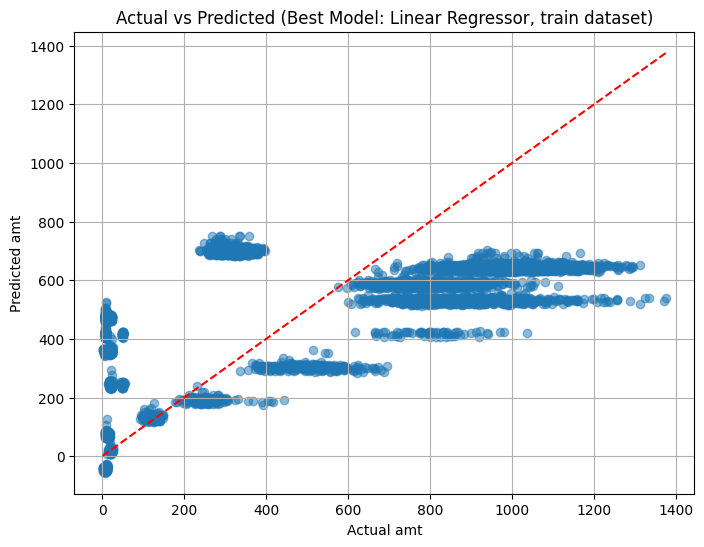

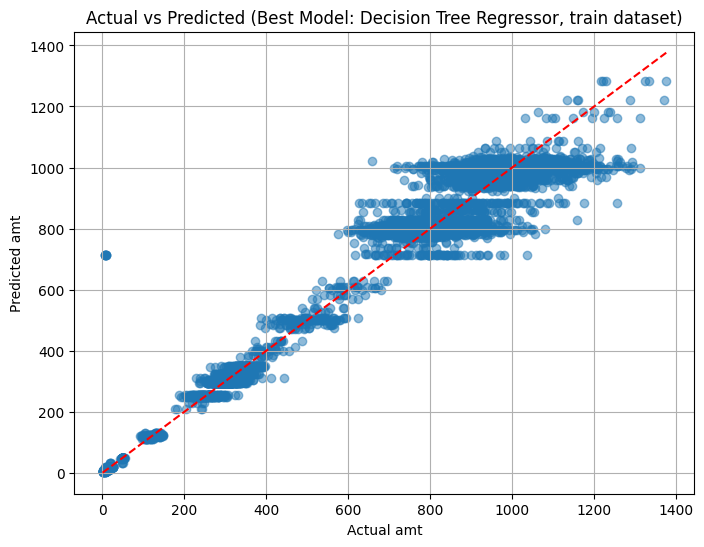

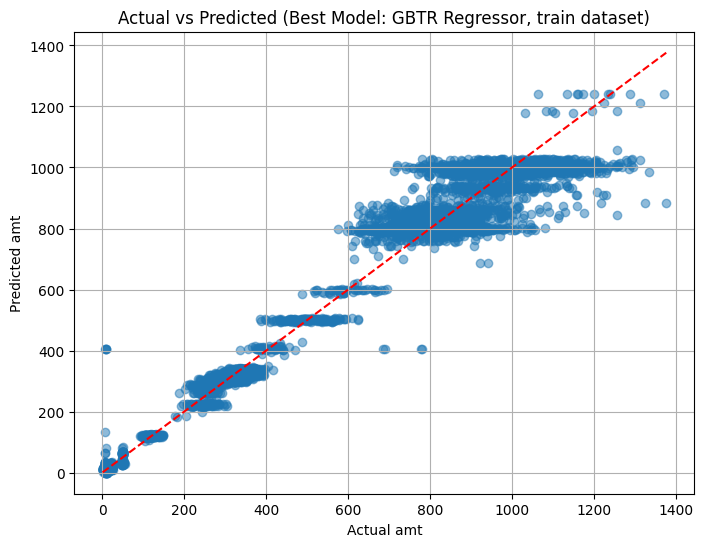

In [24]:
#printing the best model of each variation predictions 
# in scatter plot prediction vs. actual

plot_scatter_plot_of_best_model(cv_model_lr, final_train_data, 'Linear Regressor', "train")
plot_scatter_plot_of_best_model(cv_model_dtr, final_train_data_dtr, 'Decision Tree Regressor', "train")
plot_scatter_plot_of_best_model(cv_model_gbt, final_train_data_dtr, 'GBTR Regressor', "train")

In [18]:
#making of each regressor models with the best combinations of hyperparameters

lr_best=LinearRegression(labelCol='amt', featuresCol='features', regParam=0.1, fitIntercept=True, elasticNetParam=0.0, 
                        epsilon=1.5, standardization =True)
lr_model_best = lr_best.fit(final_train_data)

dtr_best=DecisionTreeRegressor(labelCol='amt', featuresCol='features', maxDepth=0, minInstancesPerNode=1)
dtr_model_best = dtr_best.fit(final_train_data_dtr)

gbt_best= GBTRegressor(labelCol='amt', featuresCol='features', maxDepth=0, minInstancesPerNode=1, stepSize=0.1)
gbt_model_best = gbt_best.fit(final_train_data_dtr)

In [19]:
#performing predictions with test dataset

predictions_lr = lr_model_best.transform(final_test_data)
predictions_dtr = dtr_model_best.transform(final_test_data_dtr)
predictions_gbt = gbt_model_best.transform(final_test_data_dtr)

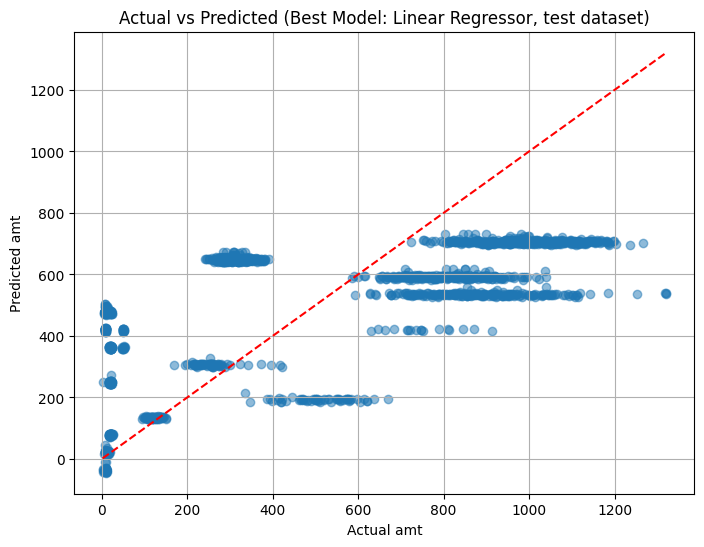

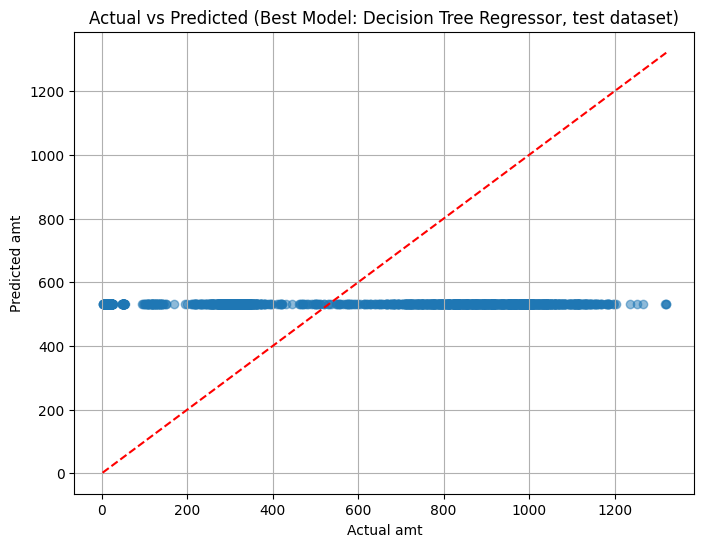

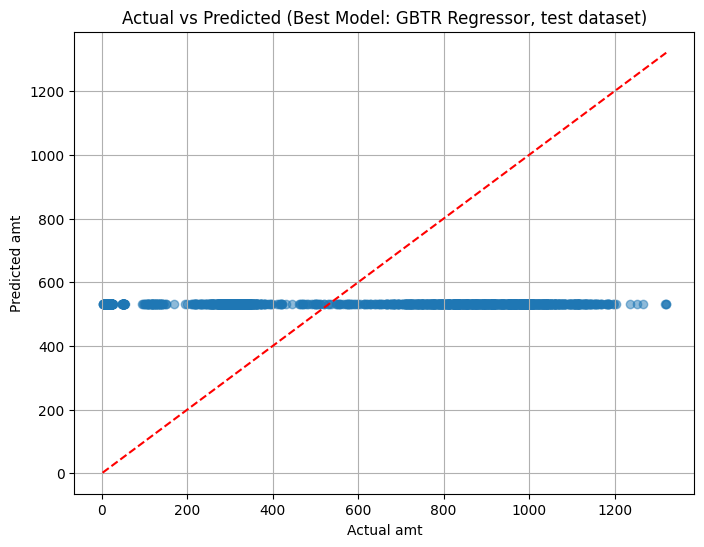

In [21]:
#ploting the results of predictions in test dataset with each model

plot_scatter_plot_of_best_model(lr_model_best, final_test_data, 'Linear Regressor', "test")
plot_scatter_plot_of_best_model(dtr_model_best, final_test_data_dtr, 'Decision Tree Regressor', "test")
plot_scatter_plot_of_best_model(gbt_model_best, final_test_data_dtr, 'GBTR Regressor', "test")

In [22]:
#printing accuracy metrics: rmse and R2 from each model on test dataset

evaluator_rmse = RegressionEvaluator(labelCol="amt", predictionCol="prediction", metricName="rmse")
rmse_lr = evaluator.evaluate(predictions_lr)
rmse_dtr = evaluator.evaluate(predictions_dtr)
rmse_gbt = evaluator.evaluate(predictions_gbt)
print("Root Mean Squared Error (RMSE) on test data: {:.3f} with Linear Regression".format(rmse_lr))
print("Root Mean Squared Error (RMSE) on test data: {:.3f} with Decision Tree Regression".format(rmse_dtr))
print("Root Mean Squared Error (RMSE) on test data: {:.3f} with GBTR Regression".format(rmse_gbt))

evaluator_r2 = RegressionEvaluator(labelCol="amt", predictionCol="prediction", metricName="r2")
r2_lr = evaluator_r2.evaluate(predictions_lr)
r2_dtr = evaluator_r2.evaluate(predictions_dtr)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)

print("R2 on test data: {:.3f} with Linear Regression".format(r2_lr))
print("R2 on test data: {:.3f} with Decision Tree Regression".format(r2_dtr))
print("R2 on test data: {:.3f} with GBTR Regression".format(r2_gbt))


Root Mean Squared Error (RMSE) on test data: 311.501 with Linear Regression
Root Mean Squared Error (RMSE) on test data: 392.667 with Decision Tree Regression
Root Mean Squared Error (RMSE) on test data: 392.667 with GBTR Regression
R2 on test data: 0.371 with Linear Regression
R2 on test data: -0.000 with Decision Tree Regression
R2 on test data: -0.000 with GBTR Regression
